$$
    % LaTeX macros
    \newcommand{\genericdel}[3]{%
      \left#1{#3}\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\poisson}{Poisson}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\od}[2]{\frac{\dif{#1}}{\dif{#2}}}
    \DeclareMathOperator{\Forall}{\forall}
    \newcommand{\iid}{iid}
    \newcommand{\indep}{\perp}
    \newcommand{\trans}{^{\intercal}}
$$

# Introduction

## Reminder of Setup

We have:
1. Noise-free outcomes $X_i$ and $Y_i$ drawn from distributions $F_X$ and $F_Y$ respectively.
2. Under the null, $F_X=F_Y$.
3. What we see are noisy-observations 
\begin{equation}
    \widetilde{X_i} = X_i + \epsilon_{X,i}
    \quad\text{and}\quad
    \widetilde{Y_i} = Y_i + \epsilon_{Y,i}
\end{equation}
4. The distribution of the errors are known, for example they can be assumed to be normal
\begin{equation}
    \epsilon_{X,i} \sim \normal\del{0, \sigma^2_{X,i}}
    \quad\text{and}\quad
    \epsilon_{Y,i} \sim \normal\del{0, \sigma^2_{Y,i}}
\end{equation}
with known variances $\sigma^2_{X,i}$ and $\sigma^2_{Y,i}$.
5. In the homoscedastic case, the focus of this notebook, all variances are the same:
\begin{equation}
\sigma^2_{X,i} = \sigma^2_{Y,j} = \sigma^2
\end{equation}

## Purpose

The purpose of this notebook is to use simulations to study the power of our tests in the homoscedastic scenario.
When the errors are the same for every observation, the KS test is valid.
Under the null, $F_X$ and $F_Y$ are the same. 
If $\sigma_{X,i}$ and $\sigma_{Y,i}$ are also all equal, then $\widetilde{X_i}$ and $\widetilde{Y_i}$ have the same distribution.

The question then becomes: when the errors are homoscedastic, is there are loss of power going from the classical KS test to the deconvolved tests that we have developed?
To be specific, I will compare three tests:
1. The **classical** KS test.
2. The **singly deconvolved** KS test: uses Fourier deconvolution to estimate the null distribution (which when then sample from to get bootstrap samples under the null), but otherwise uses the regular KS test statistic, which is the $L_\infty$ distance between the *empirical* CDFs of $\widetilde{X}$ and $\widetilde{Y}$.
3. The **doubly deconvolved** KS test: uses Fourier deconvolution to estimate the null distribution, and also uses deconvolution for the test statistic, which is the $L_\infty$ distances between the *deconvolved* CDFs of $\widetilde{X}$ and $\widetilde{Y}$.

With these three tests, I use simulations with homoscedastic errors to estimate the power under the null (should be 0.05) and under the alternative.

# Notebook setup

In [7]:
using Distributions

using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [136]:
# a few convenience functions for plotting p-values and estimating power
function plot_ecdf(x, kwargs...)
    plt.plot(sort(x), linspace(0, 1, length(x)), kwargs...)
end
sim_power(pvals) = mean(pvals .<= 0.05)
function power_se(pvals)
    p = sim_power(pvals)
    q = 1-p
    n = length(pvals)
    return √(p*q/n)
end
estimate_power(pvals) = (sim_power(pvals), power_se(pvals))
;

In [ ]:
module KS
    import DeconvolveDistribution
    using HypothesisTests
    using HypothesisTests: ApproximateTwoSampleKSTest, pvalue
    using Distributions
    using StatsBase: sample, midpoints

    include("../src/deconvolve.jl")
    include("../src/deconv_boot_test.jl")
    include("../src/test_statistics.jl")
    include("../src/simulate.jl")
    
    function sim_KS(F_X, F_Y, σ, n_X, n_Y)
        # simulate homoscedastic data
        data = sim_homo(F_X, F_Y, σ, n_X, n_Y)
        
        Xtilde = data[:Xtilde]
        Ytilde = data[:Ytilde]
        
        # classical KS test ignoring errors
        KS_test = HypothesisTests.ApproximateTwoSampleKSTest(Xtilde, Ytilde)
        KS_pval = pvalue(KS_test; tail=:both)
        
        return KS_pval
    end
    
    function sim_tests(F_X, F_Y, σ, n_X, n_Y)
        # simulate homoscedastic data
        data = sim_homo(F_X, F_Y, σ, n_X, n_Y)
        
        Xtilde = data[:Xtilde]
        Ytilde = data[:Ytilde]
        σ_X = data[:σ_X] # all the same
        σ_Y = data[:σ_Y] # all the same
        
        # classical KS test ignoring errors
        KS_test = HypothesisTests.ApproximateTwoSampleKSTest(Xtilde, Ytilde)
        KS_pval = pvalue(KS_test; tail=:both)
        
        # deconvolved KS test using classical KS test statistic
        t_KS = KS_test_statistic
        deconvKS_pval = deconv_boot_test(Xtilde, Ytilde, σ_X, σ_Y, t_KS; niter=200)
        
        # deconvolved KS test using deconvolved KS test statistic
        p = Inf # L∞ norm (KS)
        bw = 0.3
        obsmin = min(minimum(Xtilde), minimum(Ytilde))
        obsmax = max(maximum(Xtilde), maximum(Ytilde))
        xgrid = collect(linspace(obsmin-4, obsmax+4, 100))
        t_Lp = KS.distance_test_statistic(p, bw, xgrid; num_t=20)
        deconv2_pval = deconv_boot_test(Xtilde, Ytilde, σ_X, σ_Y, t_Lp; niter=200)
        
        return (KS_pval, deconvKS_pval, deconv2_pval)
    end
    
end
;

In [18]:
@time KS.sim_tests(Normal(0,2), Normal(0,2), 0.8, 200, 200)

  3.381232 seconds (212.27 k allocations: 58.882 MiB, 0.32% gc time)


(0.8642827790506041, 0.76, 0.275)

The Fourier deconvolution is slow, and for the doubly deconvolved test we need to perform it for every bootstrap sample, so each simulation takes a while (3.4 seconds).

# Power under the null

In [115]:
null_KS_arr       = Float64[]
null_deconvKS_arr = Float64[]
null_deconv2_arr  = Float64[]
;

In [125]:
tstart = now()
while now() - tstart < Dates.Hour(4) # keep doing this for 4 hours
    KS_pval, deconvKS_pval, deconv2_pval = KS.sim_tests(
        Normal(0,2), Normal(0,2), # F_X and F_Y are the same
        0.8, # σ
        200, 200 # sample sizes
        )
    push!(null_KS_arr, KS_pval)
    push!(null_deconvKS_arr, deconvKS_pval)
    push!(null_deconv2_arr, deconv2_pval)
end

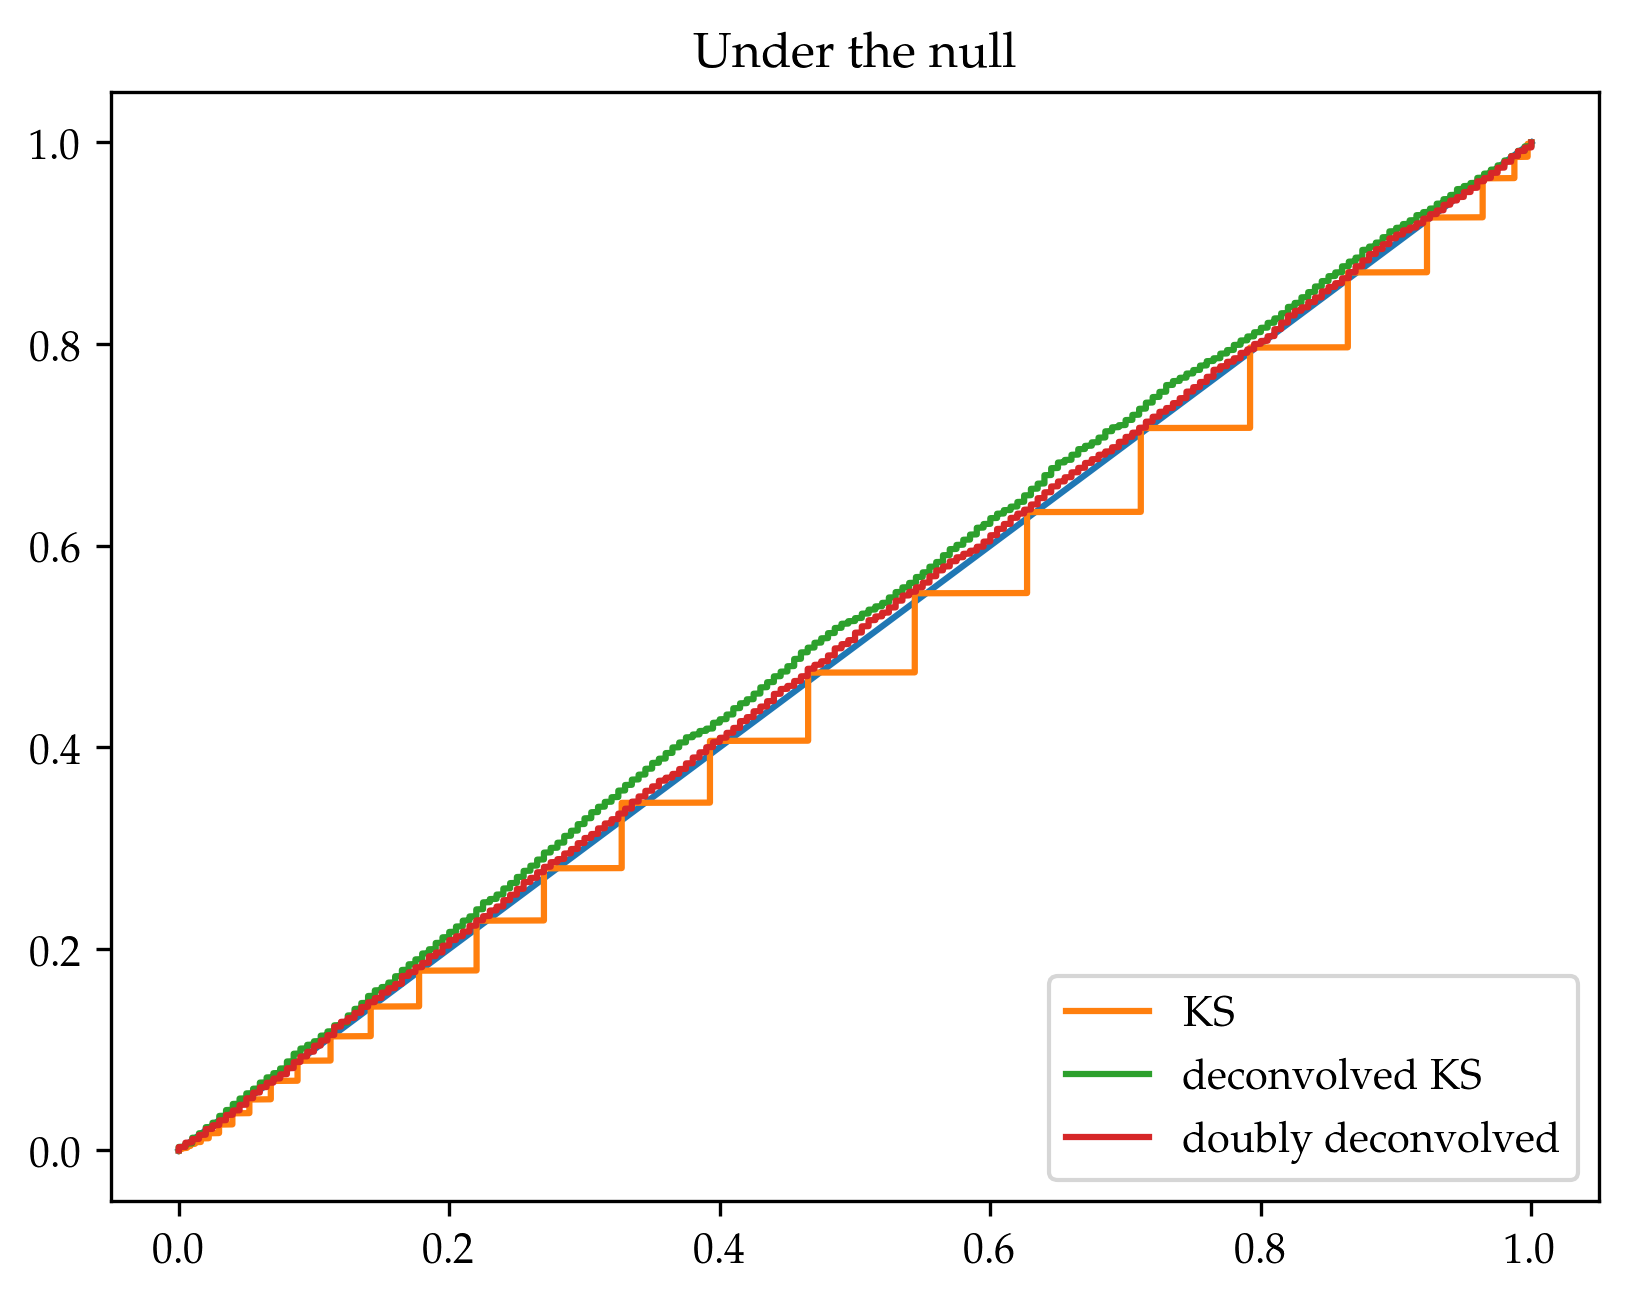

PyObject Text(0.5,1,'Under the null')

In [130]:
plt.plot([0,1], [0,1])
plot_ecdf(null_KS_arr, label="KS")
plot_ecdf(null_deconvKS_arr, label="deconvolved KS")
plot_ecdf(null_deconv2_arr, label="doubly deconvolved")
plt.legend(loc="lower right")
plt.title("Under the null")

In [138]:
@printf("Power of classical     KS test under the null: %.3f ± %.3f\n", estimate_power(null_KS_arr)...)
@printf("Power of singly-deconv KS test under the null: %.3f ± %.3f\n", estimate_power(null_deconvKS_arr)...)
@printf("Power of doubly-deconv KS test under the null: %.3f ± %.3f\n", estimate_power(null_deconv2_arr)...)

Power of classical     KS test under the null: 0.037 ± 0.003
Power of singly-deconv KS test under the null: 0.057 ± 0.004
Power of doubly-deconv KS test under the null: 0.052 ± 0.003


# Choosing alternative

In [84]:
null_KS = [KS.sim_KS(Normal(0,2), Normal(0,2), 0.8, 200, 200) for _ in 1:10000]
alt1_KS = [KS.sim_KS(Normal(0,2), Normal(0.5,2), 0.8, 200, 200) for _ in 1:10000]
alt2_KS = [KS.sim_KS(Normal(0,2), Normal(0.8,2), 0.8, 200, 200) for _ in 1:10000]
alt3_KS = [KS.sim_KS(Normal(0,2), Normal(1.0,2), 0.8, 200, 200) for _ in 1:10000]
;

In [88]:
mean(null_KS .<= 0.05)

0.0429

In [85]:
mean(alt1_KS .<= 0.05)

0.4725

In [86]:
mean(alt2_KS .<= 0.05)

0.8729

In [87]:
mean(alt3_KS .<= 0.05)

0.9763

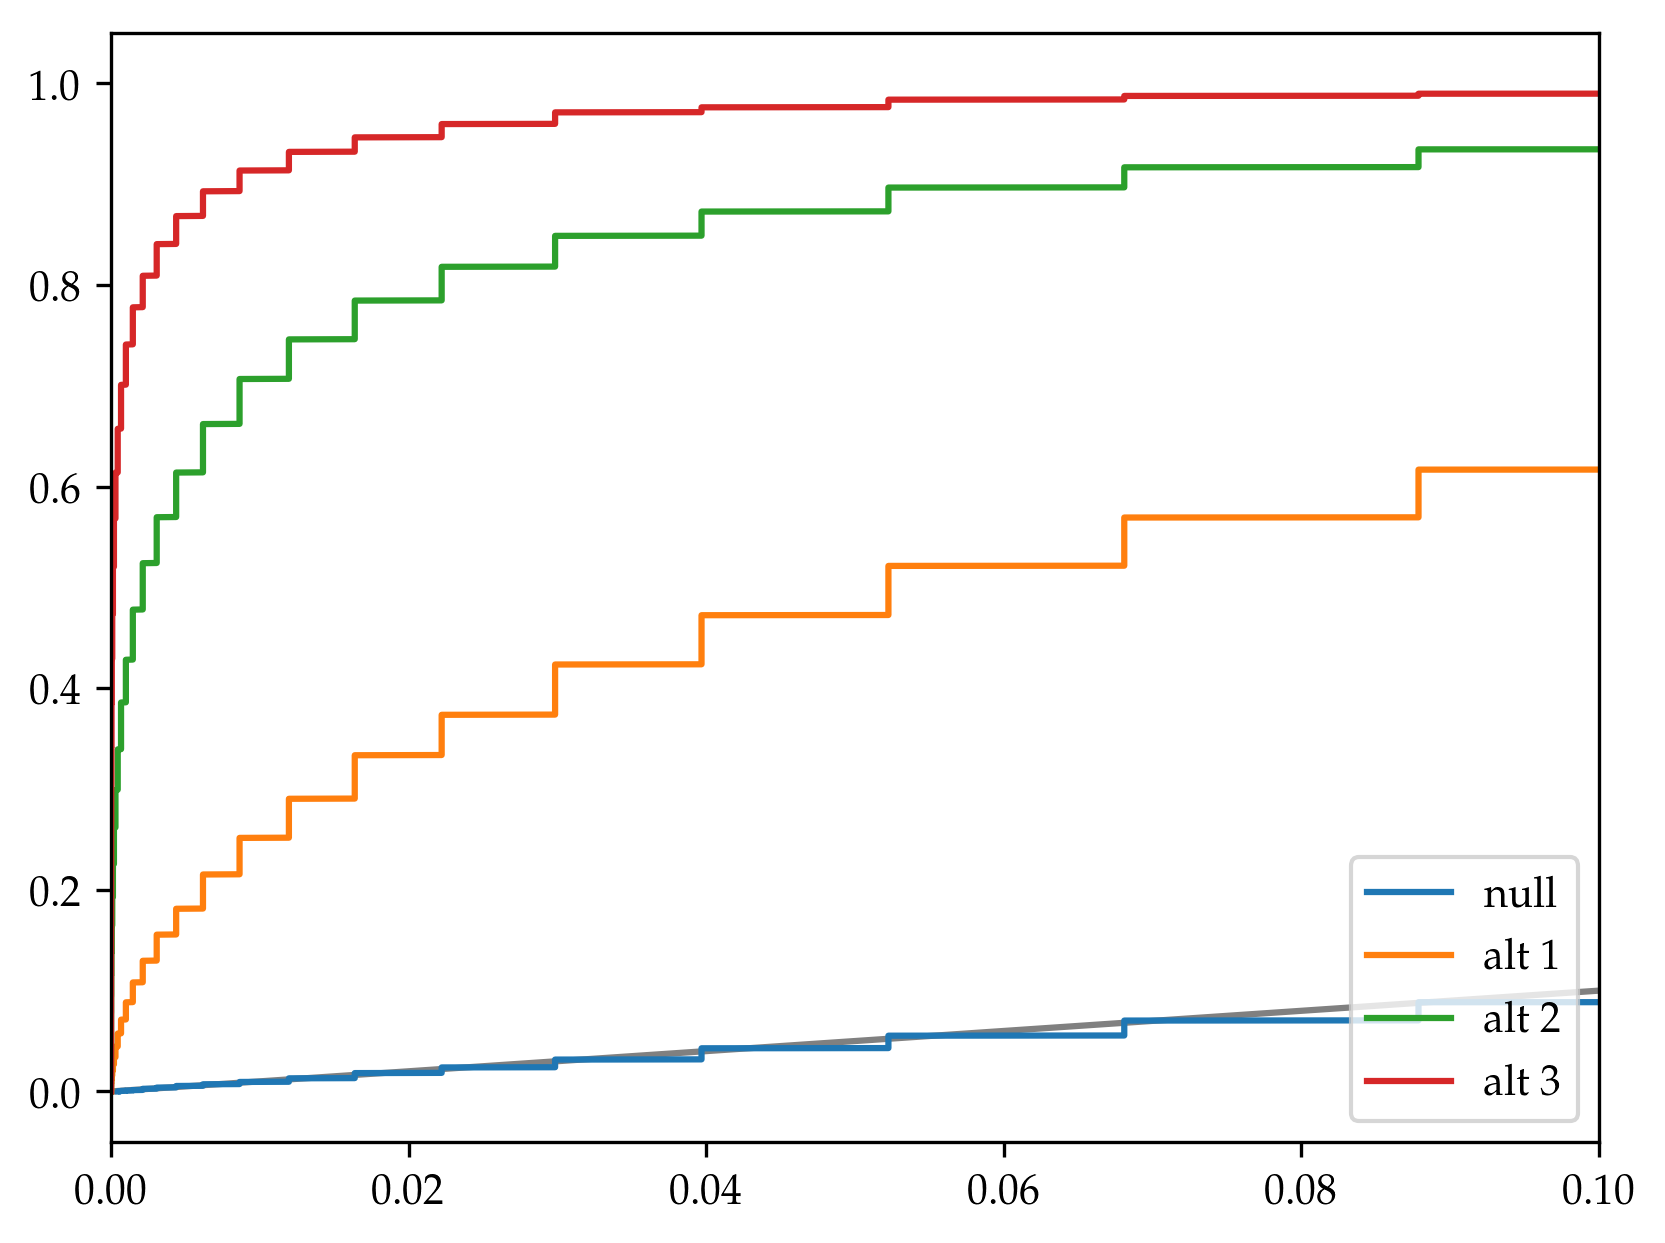

In [101]:
plt.plot([0, 1], [0, 1], color="grey")
plot_ecdf(null_KS, label="null")
plot_ecdf(alt1_KS, label="alt 1")
plot_ecdf(alt2_KS, label="alt 2")
plot_ecdf(alt3_KS, label="alt 3")
plt.legend(loc="lower right")
plt.xlim(0,0.1)
;

We will choose the alternative to have $Y \sim \mathcal{N}(0.8, 2)$, under which the power of the classical KS test is 0.8, leaving plenty of room on either side for the other tests to show their worth.

# Power under the alternative

In [119]:
alt_KS_arr       = Float64[]
alt_deconvKS_arr = Float64[]
alt_deconv2_arr  = Float64[]
;

In [126]:
tstart = now()
while now() - tstart < Dates.Hour(4)
    KS_pval, deconvKS_pval, deconv2_pval = KS.sim_tests(Normal(0,2), Normal(0.8,2), 0.8, 200, 200)
    push!(alt_KS_arr, KS_pval)
    push!(alt_deconvKS_arr, deconvKS_pval)
    push!(alt_deconv2_arr, deconv2_pval)
end

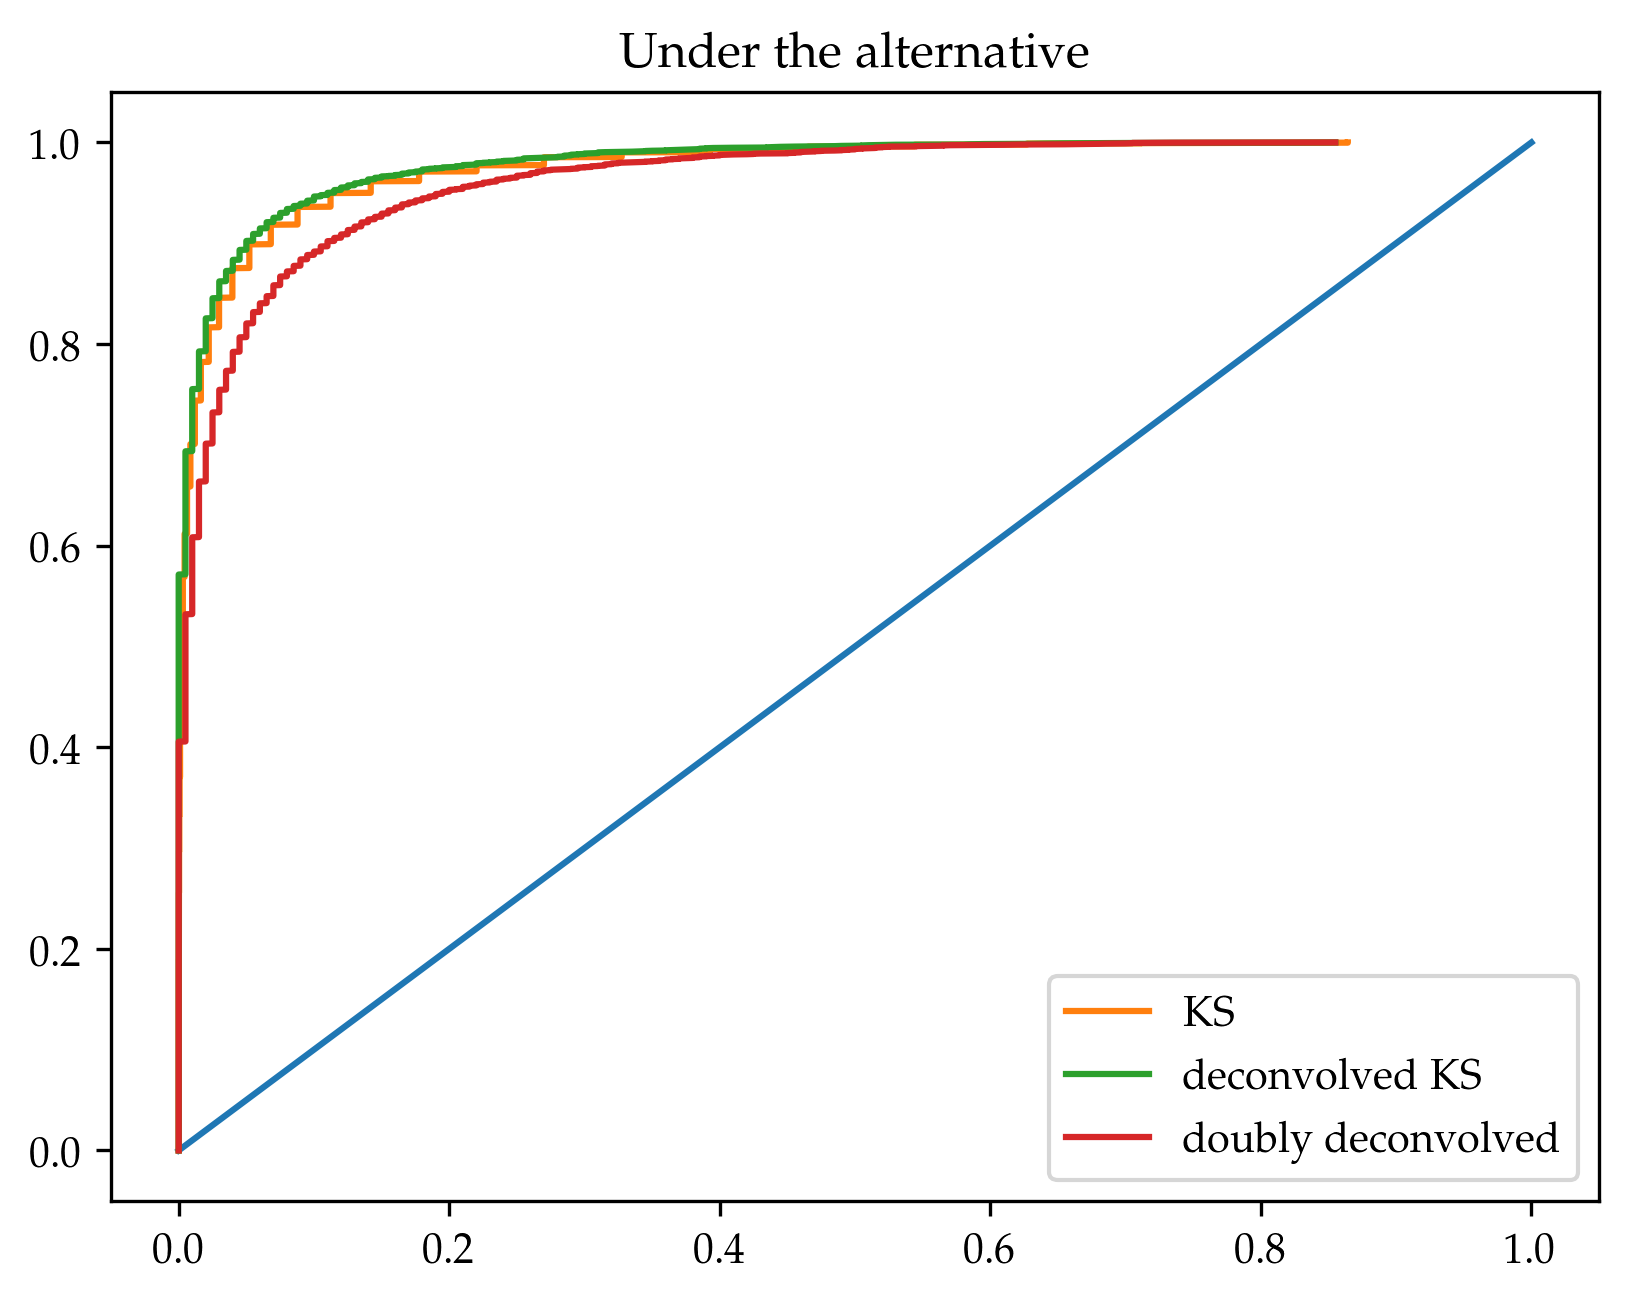

PyObject Text(0.5,1,'Under the alternative')

In [127]:
plt.plot([0,1], [0,1])
plot_ecdf(alt_KS_arr, label="KS")
plot_ecdf(alt_deconvKS_arr, label="deconvolved KS")
plot_ecdf(alt_deconv2_arr, label="doubly deconvolved")
plt.legend(loc="lower right")
plt.title("Under the alternative")

In [137]:
@printf("Power of classical     KS test under the altv: %.3f ± %.3f\n", estimate_power(alt_KS_arr)...)
@printf("Power of singly-deconv KS test under the altv: %.3f ± %.3f\n", estimate_power(alt_deconvKS_arr)...)
@printf("Power of doubly-deconv KS test under the altv: %.3f ± %.3f\n", estimate_power(alt_deconv2_arr)...)

Power of classical     KS test under the altv: 0.875 ± 0.005
Power of singly-deconv KS test under the altv: 0.902 ± 0.004
Power of doubly-deconv KS test under the altv: 0.820 ± 0.006


# Conclusion

First of all, all tests seem to be valid under the null. If anything, the classical KS test seems to be conservative.

There appears to be no loss of power going from the classical KS test to the singly deconvolved KS test.
This is how I make sense of that: as the distribution of the KS statistic under the null is supposed to be invariant to the null distribution, at least asymptotically.
In the homoscedastic case, what we're doing with the single deconvolution is to Monte Carlo the distribution of the KS statistic under a distribution, which in this case happens to be the deconvolved null.
The classical test relies on asymptotics, although there are also published tables that were also derived from Monte Carlo simulations.
It's perhaps no surprise then that the deconvolved KS test performs slightly better than the classical KS test---the power goes from 0.875 to 0.902 under the alternative.
One thing to note is the under both the null and the alternative, the distribution of $p$-values is smooth, whereas the CDF of $p$-values of the classical KS tests is a step function.

In the case of the doubly deconvolved test, there is a significant loss of power.
Under the alternative, the power dropped from 0.875 to 0.820.
It does seem like the deconvolution inside of the test statistic is erasing some information.

## Next steps
* It would be interesting to see if the Efron deconvolution retains more information.
* I think for *highly* heteroscedastic situations (like the one that motivates this project), the doubly deconvolved test will become more powerful that the singly deconvolved test. So the question becomes: how much heteroscedasticity until the power crosses over?